In [1]:
pip install opencv-contrib-python

Note: you may need to restart the kernel to use updated packages.


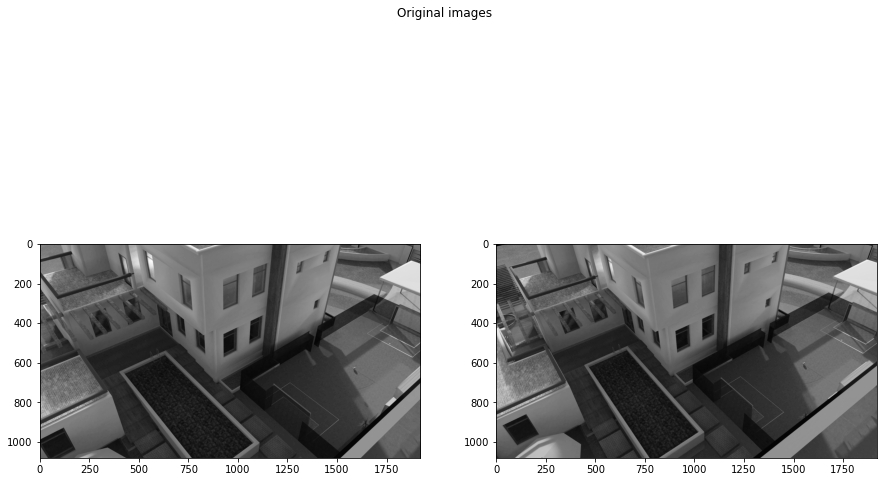

In [62]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# Read both images and convert to grayscale
img1_color = cv.imread('Frame1.png')
img2_color = cv.imread('Frame2.png')
img1 = cv.imread('Frame1.png', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('Frame2.png', cv.IMREAD_GRAYSCALE)

# ------------------------------------------------------------
# PREPROCESSING

# Compare unprocessed images
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img1, cmap="gray")
axes[1].imshow(img2, cmap="gray")
plt.suptitle("Original images")
plt.show()

In [63]:
# 1. Detect keypoints and their descriptors
# Based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html

# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

In [64]:
# Visualize keypoints
imgSift = cv.drawKeypoints(
    img1_color, kp1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv.imwrite("sift1.png", imgSift)
imgSift = cv.drawKeypoints(
    img2_color, kp1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv.imwrite("sift2.png", imgSift)

True

In [65]:
# Match keypoints in both images
# Based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)



# Keep good matches: calculate distinctive image features
# Lowe, D.G. Distinctive Image Features from Scale-Invariant Keypoints. International Journal of Computer Vision 60, 91–110 (2004). https://doi.org/10.1023/B:VISI.0000029664.99615.94
# https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf
matchesMask = [[0, 0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.6*n.distance:
        # Keep this keypoint pair
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [66]:
# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

# Keep good matches: calculate distinctive image features
# Lowe, D.G. Distinctive Image Features from Scale-Invariant Keypoints. International Journal of Computer Vision 60, 91–110 (2004). https://doi.org/10.1023/B:VISI.0000029664.99615.94
# https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf
matchesMask = [[0, 0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        # Keep this keypoint pair
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [67]:
# Draw the keypoint matches between both pictures
# Still based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html
draw_params = dict(
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask,
                   flags=cv.DrawMatchesFlags_DEFAULT)

keypoint_matches = cv.drawMatchesKnn(
    img1_color, kp1, img2_color, kp2, matches, None, **draw_params)
cv.imwrite("keypoint_matches_08.jpg", keypoint_matches)

True

In [68]:
# ------------------------------------------------------------
# STEREO RECTIFICATION

# Calculate the fundamental matrix for the cameras
# https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental_matrix, inliers = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)
print(fundamental_matrix)
# We select only inlier points
pts1 = pts1[inliers.ravel() == 1]
pts2 = pts2[inliers.ravel() == 1]


[[-3.71355577e-08 -6.26196426e-07  1.06298340e-03]
 [ 2.19732287e-06 -8.18765670e-07 -3.15463433e-02]
 [-1.68715773e-03  2.86804064e-02  1.00000000e+00]]


In [47]:
# ------------------------------------------------------------
# FUNDAMENTAL MATRIX USING 7_POINT ALGORITHM

# Calculate the fundamental matrix for the cameras
# https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental_matrix, inliers = cv.findFundamentalMat(pts1, pts2, cv.FM_7POINT)
print('7POINT')
print(fundamental_matrix)

7POINT
[[-1.98538342e-08  1.90459567e-06 -4.45923367e-04]
 [-6.16052022e-07 -1.46220170e-08 -2.71251114e-02]
 [-9.95842299e-05  2.39515422e-02  1.00000000e+00]]


In [48]:
# ------------------------------------------------------------
# FUNDAMENTAL MATRIX USING 8_POINT ALGORITHM

# Calculate the fundamental matrix for the cameras
# https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental_matrix, inliers = cv.findFundamentalMat(pts1, pts2, cv.FM_8POINT)
print('8POINT')
print(fundamental_matrix)

8POINT
[[-3.53545222e-08 -7.47461783e-07  1.10852199e-03]
 [ 2.22417655e-06 -3.77439059e-07 -3.15133072e-02]
 [-1.66780193e-03  2.83459640e-02  1.00000000e+00]]


In [52]:
# ------------------------------------------------------------
# FUNDAMENTAL MATRIX USING LMEDS ALGORITHM

# Calculate the fundamental matrix for the cameras
# https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental_matrix, inliers = cv.findFundamentalMat(pts1, pts2, cv.FM_LMEDS)
print('LMEDS')
print(fundamental_matrix)



LMEDS
[[-1.98538342e-08  1.90459567e-06 -4.45923367e-04]
 [-6.16052022e-07 -1.46220170e-08 -2.71251114e-02]
 [-9.95842299e-05  2.39515422e-02  1.00000000e+00]]


In [69]:
# Calculating the fundamental matrix using the formula in the slides" 
#[K't]x K'RK^(-1)
# K - calibration matrix 
# R - rotation matrix
# t - translation matrix 

#[]x - cross-product 
# Camerat Projection Matrix P = K[R|t]


def skew(vector):
    """
    this function returns a numpy array with the skew symmetric cross product matrix for vector.
    the skew symmetric cross product matrix is defined such that
    np.cross(a, b) = np.dot(skew(a), b)

    :param vector: An array like vector to create the skew symmetric cross product matrix for
    :return: A numpy array of the skew symmetric cross product vector
    """

    vector = np.array(vector)

    return np.array([[0, -vector.item(2), vector.item(1)],
                     [vector.item(2), 0, -vector.item(0)],
                     [-vector.item(1), vector.item(0), 0]])


K_1 = np.array([[1.600e+03, 0.000e+00, 9.595e+02],
[0.000e+00, 1.600e+03, 5.395e+02],
[0.000e+00, 0.000e+00, 1.000e+00]])

K_2 = np.array([[1.49333333e+03, 0.00000000e+00, 9.78700000e+02],
[0.00000000e+00, 1.49333333e+03, 5.20300000e+02],
[0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

R = np.array([[ 0.9971792 , -0.00348069, 0.07497863],
[ 0.00362138, 0.99999203, -0.00174044],
[-0.07497205, 0.00200697, 0.99718366]])

t = np.array([-1.98989457, 0.00265269, 0.20979508])

fund_mat = skew(K_2 @ t) @ K_2 @ R @ np.linalg.inv(K_1)

fund_mat_norm = fund_mat/fund_mat[2][2]
print(fund_mat)
print(fund_mat_norm)

#print(K_2 @ t)

[[-8.94716958e-04 -1.95802211e-01  1.10989237e+02]
 [ 5.60156937e-02  3.04586526e-03  2.93130697e+03]
 [-4.19999288e+01 -2.58338899e+03 -1.17061260e+05]]
[[ 7.64315161e-09  1.67264739e-06 -9.48129529e-04]
 [-4.78516067e-07 -2.60194129e-08 -2.50407946e-02]
 [ 3.58785894e-04  2.20686928e-02  1.00000000e+00]]


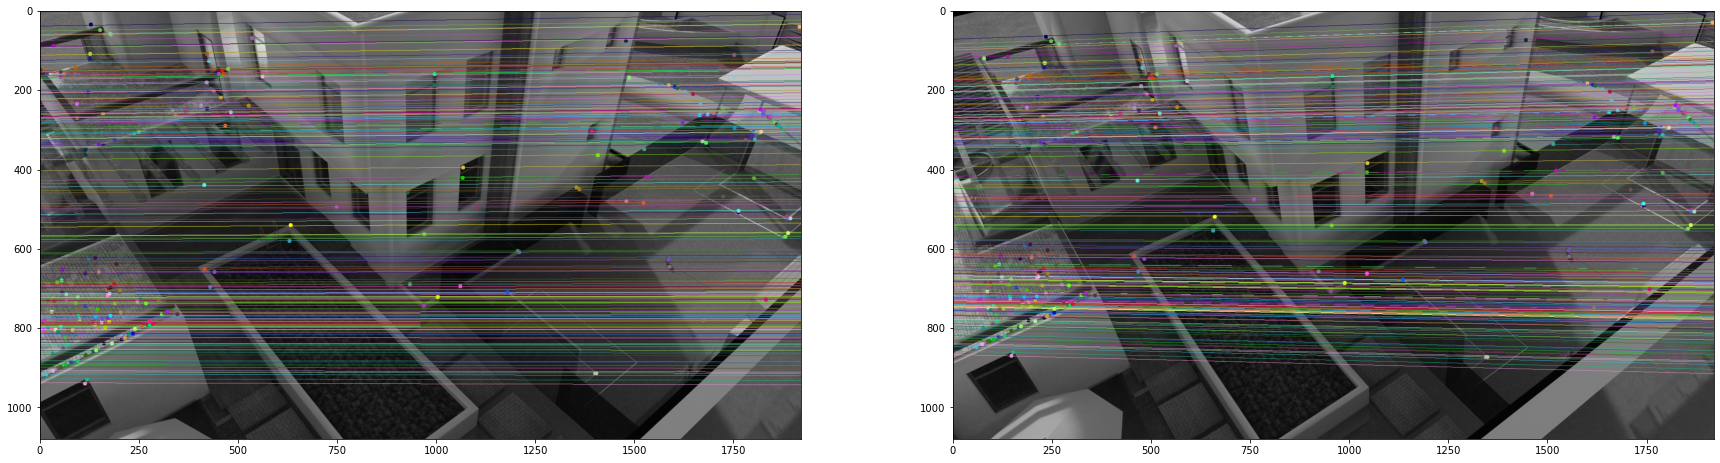

In [73]:
# Visualize epilines
# Adapted from: https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html
def drawlines(img1src, img2src, lines, pts1src, pts2src):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c = img1src.shape
    img1color = cv.cvtColor(img1src, cv.COLOR_GRAY2BGR)
    img2color = cv.cvtColor(img2src, cv.COLOR_GRAY2BGR)
    # Edit: use the same random seed so that two images are comparable!
    np.random.seed(0)
    for r, pt1, pt2 in zip(lines, pts1src, pts2src):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1color = cv.line(img1color, (x0, y0), (x1, y1), color, 1)
        img1color = cv.circle(img1color, tuple(pt1), 5, color, -1)
        img2color = cv.circle(img2color, tuple(pt2), 5, color, -1)
    return img1color, img2color


# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(
    pts2.reshape(-1, 1, 2), 2, fund_mat)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(
    pts1.reshape(-1, 1, 2), 1, fund_mat_norm)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)
plt.figure(figsize=(30, 15))
plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)

plt.show()

In [89]:
h1, w1 = img1.shape
h2, w2 = img2.shape

[success,H1,H2]= cv.stereoRectifyUncalibrated(pts1, pts2, fund_mat_norm, [w1, h1])
img1_rectified = cv.warpPerspective(img1, H1,[w1,h1])
img2_rectified = cv.warpPerspective(img2, H2,[w2,h2])
stereo = cv.StereoBM_create(numDisparities=96, blockSize=11)
disparity = stereo.compute(img1_rectified,img2_rectified)

calib_matrix_P2 = np.array([[1.600e+03, 0.000e+00, 9.595e+02],
[0.000e+00, 1.600e+03, 5.395e+02],
[0.000e+00, 0.000e+00, 1.000e+00]]
)
 
calib_matrix_P3 = np.array([[1.49333333e+03, 0.00000000e+00, 9.78700000e+02],
[0.00000000e+00, 1.49333333e+03, 5.20300000e+02],
[0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

cam1 = calib_matrix_P2 # left color image
cam2 = calib_matrix_P3 # right color image

rev_proj_matrix = np.zeros((4,4)) # to store the output

cv.stereoRectify(cameraMatrix1 = cam1,cameraMatrix2 = cam2,
                  distCoeffs1 = 0, distCoeffs2 = 0,
                  imageSize = img1.shape[:2],
                  R = R, T = t,
                  R1 = None, R2 = None,
                  P1 =  None, P2 =  None, 
                  Q = rev_proj_matrix)

(array([[ 9.99537821e-01, -4.99765913e-03, -2.99861106e-02],
        [ 4.97314014e-03,  9.99987236e-01, -8.92202217e-04],
        [ 2.99901868e-02,  7.42664729e-04,  9.99549917e-01]]),
 array([[ 9.94487265e-01, -1.32573176e-03, -1.04849040e-01],
        [ 1.41156671e-03,  9.99998727e-01,  7.44451733e-04],
        [ 1.04847920e-01, -8.88349183e-04,  9.94487871e-01]]),
 array([[1.54666666e+03, 0.00000000e+00, 1.10228683e+03, 0.00000000e+00],
        [0.00000000e+00, 1.54666666e+03, 5.19747940e+02, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00]]),
 array([[ 1.54666666e+03,  0.00000000e+00,  1.10228683e+03,
         -3.09476421e+03],
        [ 0.00000000e+00,  1.54666666e+03,  5.19747940e+02,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00]]),
 array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -1.10228683e+03],
        [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+

In [74]:
img1.shape

(1080, 1920)

<function matplotlib.pyplot.show(close=None, block=None)>

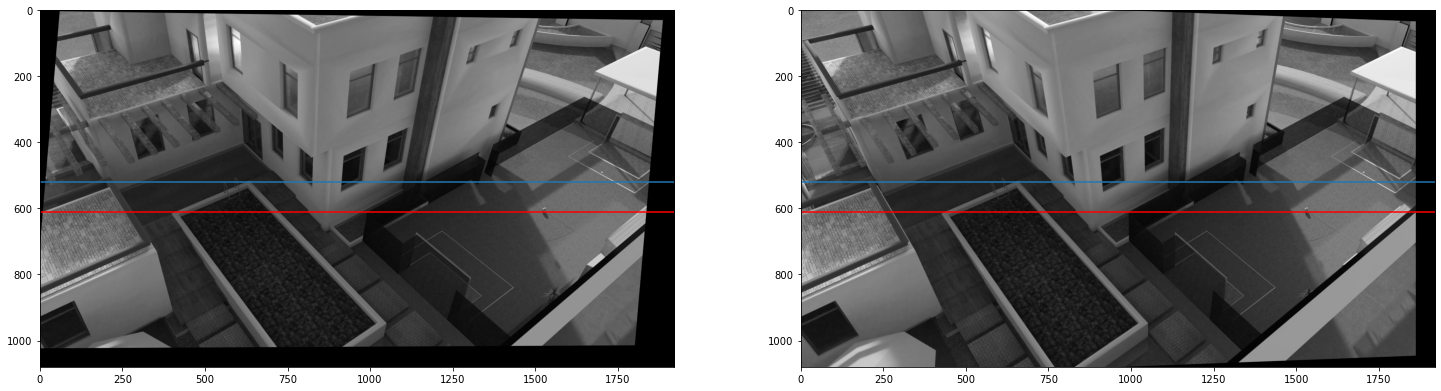

In [100]:
fig, axes = plt.subplots(1, 2, figsize = (25,10))
axes[0].imshow(img1_rectified, cmap = 'gray')
axes[1].imshow(img2_rectified, cmap = 'gray')

axes[0].axhline(610, color = 'red')
axes[1].axhline(610, color = 'red')
axes[0].axhline(520)
axes[1].axhline(520)
plt.show



<function matplotlib.pyplot.show(close=None, block=None)>

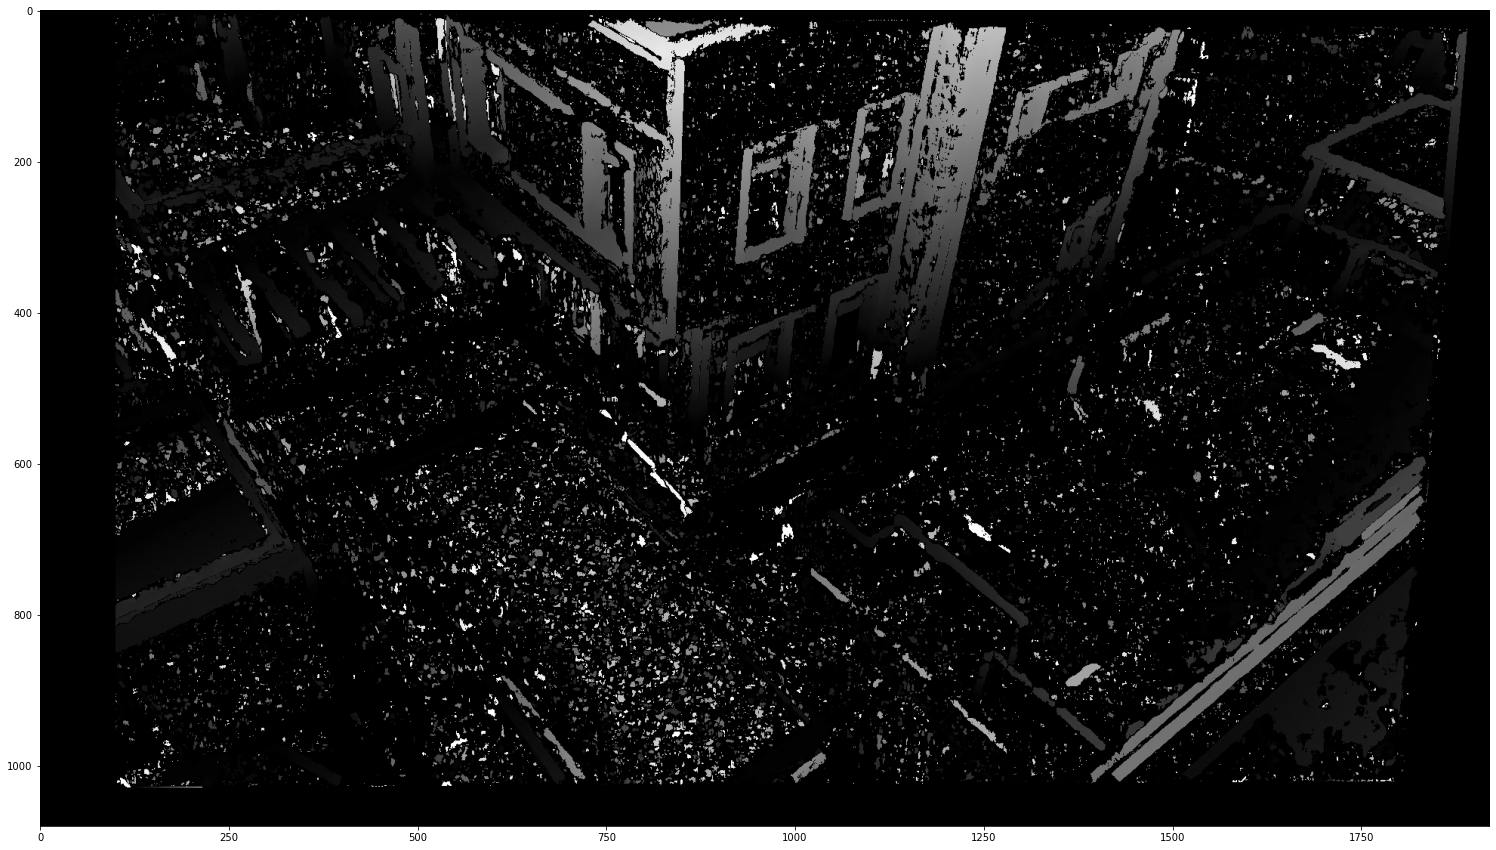

In [98]:

plt.figure(figsize=(30, 15))
plt.imshow(disparity, cmap = 'gray')
plt.show

In [80]:
img1_rectified

array([[-2.61922327e+03,  1.29181501e+02, -1.96302760e+05],
       [-4.08276167e+01, -2.58980347e+03, -5.04915197e+04],
       [-5.38326188e-02, -8.69216269e-03, -2.81241888e+03]])

In [81]:
img2_rectified

array([[ 1.03883626e+00,  3.18503181e-02, -5.15478832e+01],
       [ 3.92319954e-02,  1.00167273e+00, -2.27911016e+01],
       [ 7.27887593e-05,  2.23167523e-06,  9.58551662e-01]])